In [24]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# 1. КОНСТАНТИ ТА ПІДГОТОВКА ДАНИХ
# Кількість найбільш частих слів, які будуть використані
MAX_WORDS = 10000 
# Максимальна довжина рецензії. Більш довгі будуть обрізані, короткі доповнені нулями.
MAX_LEN = 500 
# Розмірність векторного представлення слів
EMBEDDING_DIM = 32
# Кількість епох для навчання
EPOCHS = 10
# Розмір батчу
BATCH_SIZE = 128

# Завантаження датасету IMDB
# num_words=MAX_WORDS залишає тільки MAX_WORDS найбільш частих слів.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=MAX_WORDS)

# Вирівнювання послідовностей
# Усі послідовності матимуть довжину MAX_LEN.
x_train = pad_sequences(x_train, maxlen=MAX_LEN)
x_test = pad_sequences(x_test, maxlen=MAX_LEN)

print(f"Форма тренувальних даних після pad_sequences: {x_train.shape}")
print(f"Форма тестових даних після pad_sequences: {x_test.shape}")

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Форма тренувальних даних після pad_sequences: (25000, 500)
Форма тестових даних після pad_sequences: (25000, 500)


In [3]:
# 2. ФУНКЦІЇ ДЛЯ СТВОРЕННЯ МОДЕЛЕЙ
def create_model(model_type='rnn', rnn_units=32, num_layers=1):
    """Створює та компілює різні типи рекурентних мереж."""
    model = Sequential()
    
    # 1. Шар Embedding (Створення векторного представлення слів)
    model.add(Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=MAX_LEN))
    
    # 2. Рекурентні шари
    for i in range(num_layers):
        # Перевіряємо, чи це не останній шар, щоб встановити return_sequences=True
        is_last_layer = (i == num_layers - 1)
        return_sequences = not is_last_layer
        
        if model_type == 'rnn':
            model.add(SimpleRNN(rnn_units, return_sequences=return_sequences))
        elif model_type == 'lstm':
            model.add(LSTM(rnn_units, return_sequences=return_sequences))
        elif model_type == 'bidirectional':
            # Bidirectional обгортає LSTM
            model.add(Bidirectional(LSTM(rnn_units, return_sequences=return_sequences)))
        elif model_type == 'deep_lstm':
            # Використовуємо LSTM з return_sequences=True для проміжних шарів
            if i < num_layers - 1:
                model.add(LSTM(rnn_units, return_sequences=True))
            else:
                model.add(LSTM(rnn_units, return_sequences=False))
        else:
            raise ValueError("Невідомий тип моделі")

    # 3. Шар Dropout для регуляризації
    if return_sequences is False or num_layers == 1:
        # Dropout додається тільки після виходу з рекурентного шару
        model.add(Dropout(0.5)) 

    # 4. Вихідний шар (Бінарна класифікація)
    model.add(Dense(1, activation='sigmoid'))
    
    # Компіляція
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

In [14]:
# 3. НАВЧАННЯ ТА ПОРІВНЯННЯ МОДЕЛЕЙ
# Налаштування для різних експериментів
experiments = [
    # Експеримент 1: Базова RNN
    {'name': 'Simple RNN', 'type': 'rnn', 'units': 32, 'layers': 1},
    # Експеримент 2: Базова LSTM
    {'name': 'Basic LSTM', 'type': 'lstm', 'units': 64, 'layers': 1},
    # Експеримент 3: Двостороння LSTM
    {'name': 'Bidirectional LSTM', 'type': 'bidirectional', 'units': 32, 'layers': 1},
    # Експеримент 4: Глибока LSTM (2 шари)
    {'name': 'Deep LSTM (2 Layers)', 'type': 'deep_lstm', 'units': 64, 'layers': 2},
]

results = []

for exp in experiments:
    print(f"ЕКСПЕРИМЕНТ: {exp['name']} (Тип: {exp['type']}, Шари: {exp['layers']})")
    
    # Створення моделі
    try:
        model = create_model(
            model_type=exp['type'],
            rnn_units=exp['units'],
            num_layers=exp['layers']
        )
    except ValueError as e:
        print(f"Помилка при створенні моделі: {e}")
        continue
        
    model.summary()
    
    # Навчання
    history = model.fit(
        x_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.2, # Використовуємо 20% тренувальних даних для валідації
        verbose=1
    )
    
    # Оцінка на тестовій вибірці
    print("\n--- Оцінка на тестовій вибірці ---")
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    
    # Збереження результатів
    results.append({
        'Model': exp['name'],
        'Test Loss': f"{loss:.4f}",
        'Test Accuracy': f"{accuracy*100:.2f}%",
        'Val Accuracy (Max)': f"{max(history.history['val_accuracy'])*100:.2f}%",
        'History': history.history # Зберігаємо історію для комплексного графіку
    })

ЕКСПЕРИМЕНТ: Simple RNN (Тип: rnn, Шари: 1)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.5763 - loss: 0.6711 - val_accuracy: 0.7316 - val_loss: 0.5732
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - accuracy: 0.8040 - loss: 0.4625 - val_accuracy: 0.8312 - val_loss: 0.4026
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - accuracy: 0.8476 - loss: 0.3799 - val_accuracy: 0.8238 - val_loss: 0.4113
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - accuracy: 0.8860 - loss: 0.2980 - val_accuracy: 0.8270 - val_loss: 0.4241
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - accuracy: 0.9200 - loss: 0.2190 - val_accuracy: 0.8330 - val_loss: 0.4470
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.9543 - loss: 0.1385 - val_accuracy: 0.8204 - val_loss: 0.5063
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.9770 - loss: 0.0806 - val_accuracy: 0.8132 - val_loss: 0.5578
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - accuracy: 0.8816 - loss: 0.3746 - 

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 57s 349ms/step - accuracy: 0.7005 - loss: 0.5558 - val_accuracy: 0.8414 - val_loss: 0.3779
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 53s 336ms/step - accuracy: 0.8820 - loss: 0.2981 - val_accuracy: 0.8464 - val_loss: 0.3511
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 56s 355ms/step - accuracy: 0.9208 - loss: 0.2193 - val_accuracy: 0.8566 - val_loss: 0.3338
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 52s 334ms/step - accuracy: 0.9415 - loss: 0.1695 - val_accuracy: 0.8530 - val_loss: 0.4121
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 53s 340ms/step - accuracy: 0.9492 - loss: 0.1426 - val_accuracy: 0.8820 - val_loss: 0.3348
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 54s 346ms/step - accuracy: 0.9412 - loss: 0.1608 - val_accuracy: 0.8692 - val_loss: 0.3633
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 55s 350ms/step - accuracy: 0.9512 - loss: 0.1378 - val_accuracy: 0.8570 - val_loss: 0.3891
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 56s 355ms/step - accuracy: 0.9653 - loss: 0

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 59s 357ms/step - accuracy: 0.6985 - loss: 0.5630 - val_accuracy: 0.8356 - val_loss: 0.3968
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 55s 352ms/step - accuracy: 0.8752 - loss: 0.3242 - val_accuracy: 0.8678 - val_loss: 0.3153
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 56s 355ms/step - accuracy: 0.9140 - loss: 0.2364 - val_accuracy: 0.8778 - val_loss: 0.3025
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 54s 344ms/step - accuracy: 0.9402 - loss: 0.1776 - val_accuracy: 0.8786 - val_loss: 0.3041
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 55s 351ms/step - accuracy: 0.9486 - loss: 0.1514 - val_accuracy: 0.8758 - val_loss: 0.3200
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 56s 358ms/step - accuracy: 0.9635 - loss: 0.1160 - val_accuracy: 0.8728 - val_loss: 0.4527
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 55s 351ms/step - accuracy: 0.9689 - loss: 0.0981 - val_accuracy: 0.8480 - val_loss: 0.4258
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 57s 365ms/step - accuracy: 0.8504 - loss: 0

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 127s 792ms/step - accuracy: 0.6822 - loss: 0.5966 - val_accuracy: 0.8378 - val_loss: 0.3788
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 126s 803ms/step - accuracy: 0.8742 - loss: 0.3176 - val_accuracy: 0.8698 - val_loss: 0.3218
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 125s 794ms/step - accuracy: 0.9195 - loss: 0.2201 - val_accuracy: 0.8630 - val_loss: 0.3190
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 118s 749ms/step - accuracy: 0.9359 - loss: 0.1809 - val_accuracy: 0.8644 - val_loss: 0.3475
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 116s 737ms/step - accuracy: 0.9560 - loss: 0.1328 - val_accuracy: 0.8650 - val_loss: 0.3565
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 116s 740ms/step - accuracy: 0.9635 - loss: 0.1113 - val_accuracy: 0.8782 - val_loss: 0.3913
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 116s 740ms/step - accuracy: 0.9740 - loss: 0.0838 - val_accuracy: 0.8620 - val_loss: 0.4125
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 120s 767ms/step - accuracy: 0.9775 -

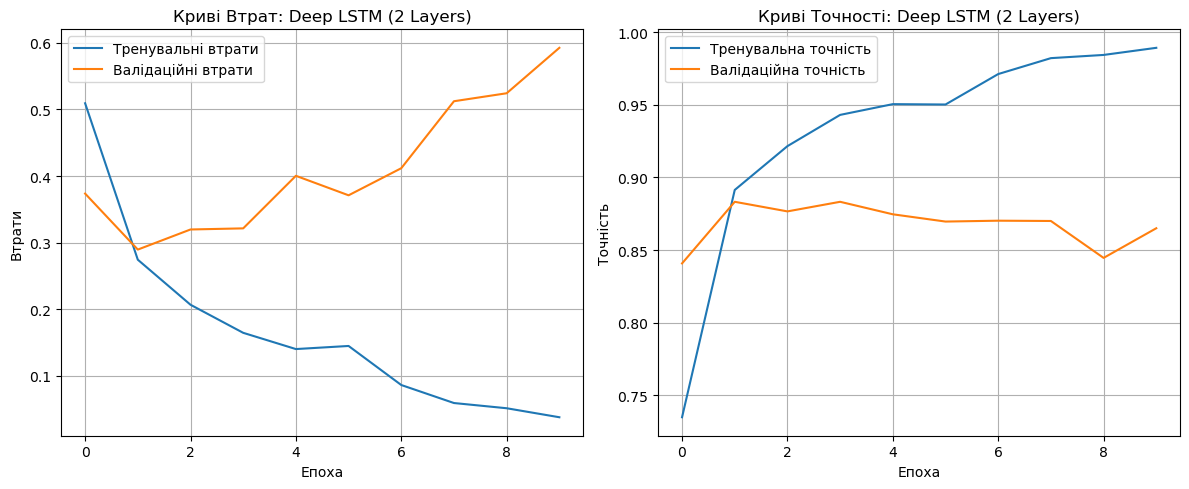

In [8]:
# Виводимо окремі графіки тільки для повної інформації, 
# але головним є комплексний графік після циклу.
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Тренувальні втрати')
plt.plot(history.history['val_loss'], label='Валідаційні втрати')
plt.title(f'Криві Втрат: {exp["name"]}')
plt.xlabel('Епоха')
plt.ylabel('Втрати')
plt.legend()
plt.grid(True)
    
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Тренувальна точність')
plt.plot(history.history['val_accuracy'], label='Валідаційна точність')
plt.title(f'Криві Точності: {exp["name"]}')
plt.xlabel('Епоха')
plt.ylabel('Точність')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Модель Simple RNN: 83.30%
Модель Basic LSTM: 88.20%
Модель Bidirectional LSTM: 87.86%
Модель Deep LSTM (2 Layers): 87.82%


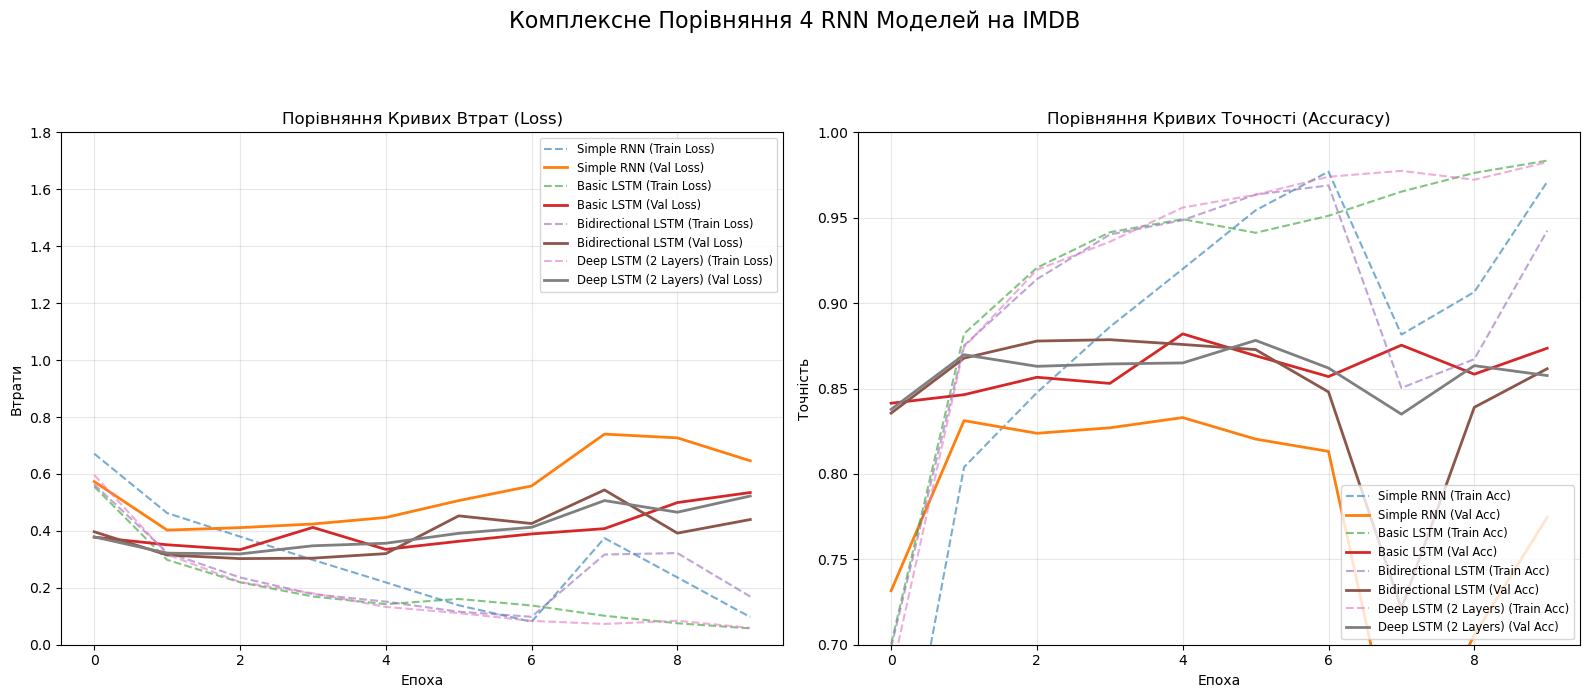

In [37]:
for res in results:
    # Отримуємо максимальне значення точності та форматуємо
    max_val_acc_str = res['Val Accuracy (Max)']
    print(f"Модель {res['Model']}: {max_val_acc_str}")

plt.figure(figsize=(16, 7))

# --- Підграфік 1: ПОРІВНЯННЯ ВТРАТ (LOSS) ---
plt.subplot(1, 2, 1)
for res in results:
    model_name = res['Model']
    # Тренувальні втрати (пунктир)
    plt.plot(res['History']['loss'], linestyle='--', alpha=0.6, label=f'{model_name} (Train Loss)')
    # Валідаційні втрати (суцільна лінія)
    plt.plot(res['History']['val_loss'], linestyle='-', linewidth=2, label=f'{model_name} (Val Loss)')

plt.title('Порівняння Кривих Втрат (Loss)')
plt.xlabel('Епоха')
plt.ylabel('Втрати')
plt.legend(loc='upper right', fontsize='small')
plt.grid(True, alpha=0.3)
# Розширення діапазону осі Y для відображення початкових високих втрат
plt.ylim(0.0, 1.8) 

# --- Підграфік 2: ПОРІВНЯННЯ ТОЧНОСТІ (ACCURACY) ---
plt.subplot(1, 2, 2)
for res in results:
    model_name = res['Model']
    # Тренувальна точність (пунктир)
    plt.plot(res['History']['accuracy'], linestyle='--', alpha=0.6, label=f'{model_name} (Train Acc)')
    # Валідаційна точність (суцільна лінія)
    plt.plot(res['History']['val_accuracy'], linestyle='-', linewidth=2, label=f'{model_name} (Val Acc)')

plt.title('Порівняння Кривих Точності (Accuracy)')
plt.xlabel('Епоха')
plt.ylabel('Точність')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True, alpha=0.3)
plt.ylim(0.7, 1.0) # Обмеження осі Y для кращої видимості

plt.suptitle('Комплексне Порівняння 4 RNN Моделей на IMDB', fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Враховуємо заголовок
plt.show()

***Аналіз Комплексного Порівняння 4 RNN Моделей на IMDB***


Надані графіки демонструють динаміку навчання (криві втрат та точності) чотирьох різних рекурентних нейронних мереж (RNN, Basic LSTM, Bidirectional LSTM, Deep LSTM) протягом 10 епох набору даних IMDB.


1. Порівняння Кривих Втрат (Loss)


***Ключові спостереження:***


**Тренувальні Втрати (Пунктирні лінії):**


Усі моделі, крім Simple RNN, демонструють швидке зниження тренувальних втрат, наближаючись до нуля.


Deep LSTM (2 Layers) та Basic LSTM показали найшвидше та найглибше зниження, досягнувши найнижчих значень втрат (близько 0.05) на останніх епохах. Це вказує на їхню високу здатність запам'ятовувати тренувальний набір.


Simple RNN (блакитна пунктирна лінія) має найгіршу динаміку: її втрати знижуються повільно і залишаються значно вищими (близько 0.15–0.35) навіть на останніх епохах. Це класичний прояв проблеми зникаючого градієнту при роботі з довгими послідовностями (500 слів).


**Валідаційні Втрати (Суцільні лінії):**


Bidirectional LSTM (коричнева лінія) демонструє найбільш стабільні та низькі валідаційні втрати (близько 0.35) у другій половині навчання, що свідчить про найкращу генералізацію.


Simple RNN (помаранчева лінія) має найвищі валідаційні втрати, які навіть починають зростати після 5-ї епохи, підтверджуючи її слабку здатність до узагальнення.


Deep LSTM (сіра лінія) демонструє гарну динаміку, але має більші коливання порівняно з Bidirectional LSTM.


2. Порівняння Кривих Точності (Accuracy)


***Ключові спостереження:***


**Тренувальна Точність (Пунктирні лінії):**


LSTM-базовані моделі (Basic, Bidirectional, Deep) швидко досягають дуже високої тренувальної точності (понад 95%). Deep LSTM і Basic LSTM наближаються до 98%.


Це підтверджує, що ці моделі успішно вивчають складні закономірності в тренувальних даних, але одночасно сигналізує про сильне перенавчання (overfitting), оскільки різниця між тренувальною та валідаційною точністю стає дуже великою.


**Валідаційна Точність (Суцільні лінії):**


Bidirectional LSTM (коричнева лінія) досягає найвищої пікової валідаційної точності близько 88%. Це робить її найкращою моделлю.


Simple RNN (помаранчева лінія) залишається найслабшою моделлю з піком близько 84%.


Усі моделі, досягають свого піку валідаційної точності приблизно між 4-ю та 7-ю епохами, після чого точність починає коливатися або знижуватися. Це точка для ранньої зупинки (Early Stopping).


3. Висновок:


Продуктивність: Найкращі результати (найнижчі валідаційні втрати та найвища валідаційна точність) демонструють Bidirectional LSTM та Basic LSTM. Вони найкраще впоралися з проблемою довгострокових залежностей у тексті.


Перенавчання (Overfitting): Усі моделі, відчувають значне перенавчання вже після 5-ї епохи (тренувальна точність продовжує зростати, тоді як валідаційна – стабілізується або падає).


Неефективність Simple RNN: Модель Simple RNN є явно неефективною для цього завдання через велику довжину послідовностей, що спричиняє проблему зникаючого градієнту.





In [27]:
# 1. КОНСТАНТИ(Bidirectional LSTM)
# Розмірність векторного представлення слів
EMBEDDING_DIM = 128 # Збільшено розмірність для кращого представлення
LSTM_UNITS = 128     # Одиниці LSTM для оптимізованої моделі

# ОПТИМІЗОВАНІ ПАРАМЕТРИ ДЛЯ РЕГУЛЯРИЗАЦІЇ ТА РАННЬОЇ ЗУПИНКИ
L2_REG_STRENGTH = 1e-4  # Сила L2 регуляризації
DROPOUT_RNN = 0.2       # Dropout всередині LSTM (Recurrent and kernel)
DROPOUT_DENSE = 0.3     # Dropout після рекурентного шару
PATIENCE_EPOCHS = 4     # Patience для Early Stopping (кількість епох для очікування)
MAX_EPOCHS = 30         # Збільшимо максимальну кількість епох, Early Stopping захистить від Overfitting
BATCH_SIZE = 128

In [28]:
# 2. ФУНКЦІЯ СТВОРЕННЯ МОДЕЛІ (ОНОВЛЕНА) 
def create_optimized_bidirectional_model(rnn_units=LSTM_UNITS, num_layers=1):
    """
    Створює та компілює оптимізовану модель Bidirectional LSTM
    з L2-регуляризацією та Dropout.
    """
    model = Sequential()
    
    # 1. Шар Embedding
    model.add(Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=MAX_LEN))
    
    # 2. Bidirectional LSTM з регуляризацією
    # return_sequences=False, оскільки це останній рекурентний шар.
    # Додано kernel_regularizer, dropout та recurrent_dropout.
    model.add(Bidirectional(
        LSTM(rnn_units, 
             return_sequences=False,
             dropout=DROPOUT_RNN,
             recurrent_dropout=DROPOUT_RNN,
             kernel_regularizer=l2(L2_REG_STRENGTH)
        )
    ))

    # 3. Шар Dropout для регуляризації Dense-шару
    model.add(Dropout(DROPOUT_DENSE))

    # 4. Вихідний шар (Бінарна класифікація)
    model.add(Dense(1, activation='sigmoid'))
    
    # Компіляція
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

In [29]:
# 3. НАВЧАННЯ ОПТИМІЗОВАНОЇ МОДЕЛІ 
# Створення колбеку Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',         # Відстежуємо валідаційні втрати
    patience=PATIENCE_EPOCHS,   # Чекаємо 4 епохи без покращення
    restore_best_weights=True,  # Повертаємо найкращі ваги
    verbose=1
)

# Створення моделі
model = create_optimized_bidirectional_model(rnn_units=LSTM_UNITS, num_layers=1)
model.summary()

# Навчання з Early Stopping
history = model.fit(
    x_train, y_train,
    epochs=MAX_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2, # Використовуємо 20% тренувальних даних для валідації
    callbacks=[early_stopping],
    verbose=1
)

# 4. Оцінка на тестовій вибірці
print("\n--- ФІНАЛЬНА ОЦІНКА ОПТИМІЗОВАНОЇ МОДЕЛІ НА ТЕСТОВІЙ ВИБІРЦІ ---")
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)

# Збереження результатів
final_result = {
    'Model': 'Optimized Bidirectional LSTM',
    'Test Loss': f"{loss:.4f}",
    'Test Accuracy': f"{accuracy*100:.2f}%",
    'Val Accuracy (Max)': f"{max(history.history['val_accuracy'])*100:.2f}%",
    'History': history.history
}

print(f"Модель: {final_result['Model']}")
print(f"Фінальна точність на тесті: {final_result['Test Accuracy']}")
print(f"Максимальна точність на валідації: {final_result['Val Accuracy (Max)']}")

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 1197s 8s/step - accuracy: 0.7359 - loss: 0.5323 - val_accuracy: 0.7860 - val_loss: 0.5633
Epoch 2/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 1419s 9s/step - accuracy: 0.8451 - loss: 0.3772 - val_accuracy: 0.8400 - val_loss: 0.3985
Epoch 3/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 1481s 9s/step - accuracy: 0.8746 - loss: 0.3190 - val_accuracy: 0.8436 - val_loss: 0.4002
Epoch 4/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 1471s 9s/step - accuracy: 0.9018 - loss: 0.2677 - val_accuracy: 0.8490 - val_loss: 0.3750
Epoch 5/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 1493s 10s/step - accuracy: 0.9111 - loss: 0.2454 - val_accuracy: 0.8570 - val_loss: 0.3912
Epoch 6/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 1576s 10s/step - accuracy: 0.9107 - loss: 0.2419 - val_accuracy: 0.8258 - val_loss: 0.4226
Epoch 7/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 4224s 27s/step - accuracy: 0.9209 - loss: 0.2158 - val_accuracy: 0.8400 - val_loss: 0.4437
Epoch 8/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 57626s 369s/step - accuracy: 0.9299 - loss: 0.2

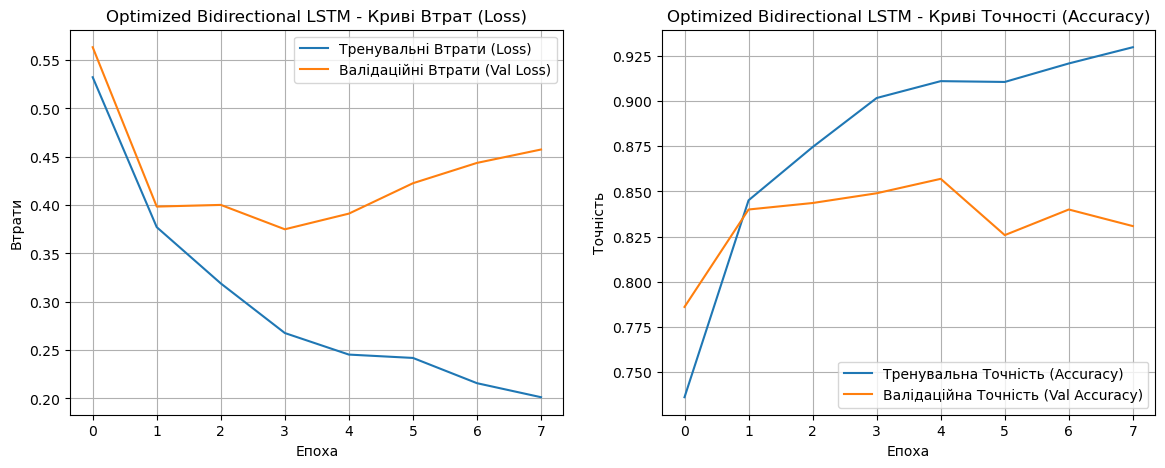

In [30]:
# 5. Побудова графіків (Діагностика)
plt.figure(figsize=(14, 5))

# Графік втрат
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Тренувальні Втрати (Loss)')
plt.plot(history.history['val_loss'], label='Валідаційні Втрати (Val Loss)')
plt.title(f"{final_result['Model']} - Криві Втрат (Loss)")
plt.xlabel('Епоха')
plt.ylabel('Втрати')
plt.legend()
plt.grid(True)

# Графік точності
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Тренувальна Точність (Accuracy)')
plt.plot(history.history['val_accuracy'], label='Валідаційна Точність (Val Accuracy)')
plt.title(f"{final_result['Model']} - Криві Точності (Accuracy)")
plt.xlabel('Епоха')
plt.ylabel('Точність')
plt.legend()
plt.grid(True)

plt.show()

**Висновок**

Остання спроба оптимізації, де було збільшено потужність моделі (з LSTM_UNITS=64 до 128) і зменшено регуляризацію (Dropout), призвела до погіршення результату.

Поточна модель з 85.70% програє оригінальній Bidirectional LSTM (87.86%) та Basic LSTM (88.20%).


In [31]:
# 1. КОНСТАНТИ ТА ПІДГОТОВКА ДАНИХ
# Кількість найбільш частих слів, які будуть використані
MAX_WORDS = 10000
# Максимальна довжина рецензії
MAX_LEN = 500
# Розмірність векторного представлення слів
EMBEDDING_DIM = 128
# Кількість одиниць LSTM
LSTM_UNITS = 64 # Найбільш успішний розмір

# ОПТИМІЗОВАНІ ПАРАМЕТРИ
L2_REG_STRENGTH = 1e-4  # Сила L2 регуляризації
DROPOUT_RNN = 0.1       # Dropout всередині LSTM (пом'якшено)
DROPOUT_DENSE = 0.2     # Dropout після рекурентного шару (пом'якшено)
PATIENCE_EPOCHS = 4     # Patience для Early Stopping
MAX_EPOCHS = 30         
BATCH_SIZE = 128

In [33]:
# 2. ФУНКЦІЯ СТВОРЕННЯ МОДЕЛІ(Basic LSTM)
def create_optimized_lstm_model(rnn_units=LSTM_UNITS):
    """
    Створює та компілює оптимізовану модель Basic LSTM
    з м'якою регуляризацією та Early Stopping.
    """
    model = Sequential()
    
    # 1. Шар Embedding
    model.add(Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=MAX_LEN))
    
    # 2. Шар LSTM з регуляризацією
    rnn_kwargs = {
        'return_sequences': False,
        'dropout': DROPOUT_RNN,
        'recurrent_dropout': DROPOUT_RNN,
        'kernel_regularizer': l2(L2_REG_STRENGTH)
    }

    model.add(LSTM(rnn_units, **rnn_kwargs))
    
    # 3. Шар Dropout для регуляризації Dense-шару
    model.add(Dropout(DROPOUT_DENSE))

    # 4. Вихідний шар (Бінарна класифікація)
    model.add(Dense(1, activation='sigmoid'))
    
    # Компіляція
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

In [34]:
# 3. НАВЧАННЯ МОДЕЛІ 
# Створення колбеку Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',         # Відстежуємо валідаційні втрати
    patience=PATIENCE_EPOCHS,   # Чекаємо 4 епохи без покращення
    restore_best_weights=True,  # Повертаємо найкращі ваги
    verbose=1
)

# Створення моделі
model = create_optimized_lstm_model(rnn_units=LSTM_UNITS)
model.summary()

print("\n--- ПОЧАТОК НАВЧАННЯ OPTIMIZED BASIC LSTM (L=64, D=0.1/0.2) ---")

# Навчання з Early Stopping
history = model.fit(
    x_train, y_train,
    epochs=MAX_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2, # Використовуємо 20% тренувальних даних для валідації
    callbacks=[early_stopping],
    verbose=1
)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


--- ПОЧАТОК НАВЧАННЯ OPTIMIZED BASIC LSTM (L=64, D=0.1/0.2) ---
Epoch 1/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 304s 2s/step - accuracy: 0.7501 - loss: 0.5212 - val_accuracy: 0.8400 - val_loss: 0.3831
Epoch 2/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - accuracy: 0.8587 - loss: 0.3465 - val_accuracy: 0.8142 - val_loss: 0.4161
Epoch 3/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 318s 2s/step - accuracy: 0.8924 - loss: 0.2877 - val_accuracy: 0.8552 - val_loss: 0.3775
Epoch 4/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 312s 2s/step - accuracy: 0.9047 - loss: 0.2592 - val_accuracy: 0.8620 - val_loss: 0.3585
Epoch 5/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 418s 3s/step - accuracy: 0.9144 - loss: 0.2360 - val_accuracy: 0.8374 - val_loss: 0.4031
Epoch 6/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 312s 2s/step - accuracy: 0.9295 - loss: 0.2005 - val_accuracy: 0.8488 - val_loss: 0.4097
Epoch 7/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 2183s 14s/step - accuracy: 0.9398 - loss: 0.1757 - val_accuracy: 0.8538 - val_loss: 0.4167
Epoch 8/30
157/157 ━━━━━━━━━━━

In [35]:
# 4. Оцінка на тестовій вибірці
print("\n--- ФІНАЛЬНА ОЦІНКА НА ТЕСТОВІЙ ВИБІРЦІ ---")
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)

# Виведення результатів
print(f"Модель: Optimized Basic LSTM (Units={LSTM_UNITS})")
print(f"Фінальна точність на тесті: {accuracy*100:.2f}%")
print(f"Максимальна точність на валідації: {max(history.history['val_accuracy'])*100:.2f}%")


--- ФІНАЛЬНА ОЦІНКА НА ТЕСТОВІЙ ВИБІРЦІ ---
Модель: Optimized Basic LSTM (Units=64)
Фінальна точність на тесті: 85.88%
Максимальна точність на валідації: 86.20%


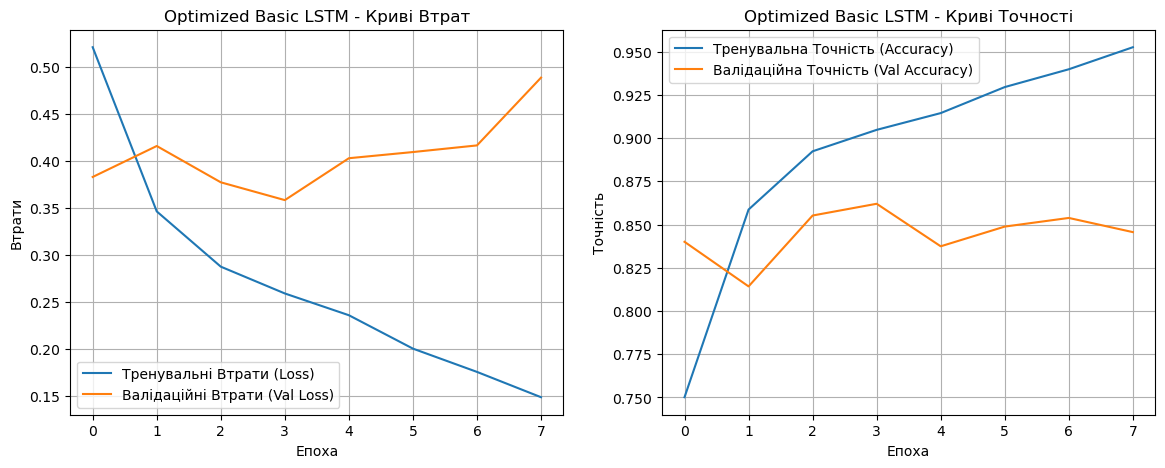

In [36]:
# 5. Побудова графіків
plt.figure(figsize=(14, 5))

# Графік втрат
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Тренувальні Втрати (Loss)')
plt.plot(history.history['val_loss'], label='Валідаційні Втрати (Val Loss)')
plt.title('Optimized Basic LSTM - Криві Втрат')
plt.xlabel('Епоха')
plt.ylabel('Втрати')
plt.legend()
plt.grid(True)

# Графік точності
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Тренувальна Точність (Accuracy)')
plt.plot(history.history['val_accuracy'], label='Валідаційна Точність (Val Accuracy)')
plt.title('Optimized Basic LSTM - Криві Точності')
plt.xlabel('Епоха')
plt.ylabel('Точність')
plt.legend()
plt.grid(True)

plt.show()

**Короткий висновок**

**Погіршення узагальнення:** 


Зниження точності на $2.32\%$ вказує на те, що запропоновані параметри регуляризації (DROPOUT_RNN=0.1, DROPOUT_DENSE=0.2) та L2 були занадто сильними для цієї архітектури.
    

**Наслідок:** 


Замість запобігання перенавчанню, ці параметри спричинили недонавчання, зменшивши її загальну потужність і ефективність.


**Фінальний результат:** 


Найкращим рішенням залишається Basic LSTM, оскільки її початкова архітектура була найбільш ефективною.
